In [0]:
from __future__ import division, print_function
from builtins import range

%matplotlib inline
import autograd.numpy as np
from autograd import grad
np.random.seed(123)
import time as time
import matplotlib.pyplot as plt
import pandas as pd
import os as os
from PIL import Image  




<h1><center>Exercise 1: Film Recommendation</center></h1>

### Data Dowload
Download the "rating_matrix.npy" on the IVLE. This file contains the $13$ millions of film ratings.


In [0]:
path = "/Users/apple/Downloads/netflix-prize-data"
data_netflix = np.load(os.path.join(path, "rating_matrix.npy"))


In [0]:
#first colum: USER_ID
#second colum: FILM_ID
#third colum: RATING_ID

print("USER_ID \t FILM_ID \t RATING")
print(data_netflix[:10])

USER_ID 	 FILM_ID 	 RATING
[[56210   138     3]
 [52985   120     3]
 [23195    64     4]
 [50206  1277     4]
 [29840   130     3]
 [59551    54     1]
 [66413    37     3]
 [32666    98     3]
 [69911     6     5]
 [28913    41     4]]


In [0]:
n_users = len(np.unique(data_netflix[:,0]))
n_films = len(np.unique(data_netflix[:,1]))
n_ratings = len(data_netflix)
print("Total Number of Ratings = ", n_ratings)
print("Total Number of Users = ", n_users)
print("Total Number of Films = ", n_films)


Total Number of Ratings =  13119291
Total Number of Users =  70775
Total Number of Films =  3314


Text(0,0.5,'Proba')

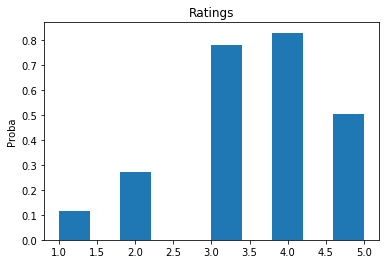

In [0]:
H = plt.hist(data_netflix[:,2], density=True)
plt.title("Ratings")
plt.ylabel("Proba")

In [0]:
#compute the number of ratings of each user
nb_rating_per_user = np.zeros(n_users)
nb_rating_per_film = np.zeros(n_films)
for k in range(n_ratings):
    user = data_netflix[k,0]
    film = data_netflix[k,1]
    nb_rating_per_user[user] += 1
    nb_rating_per_film[film] += 1

Text(0.5,1,'Number Ratings per Film')

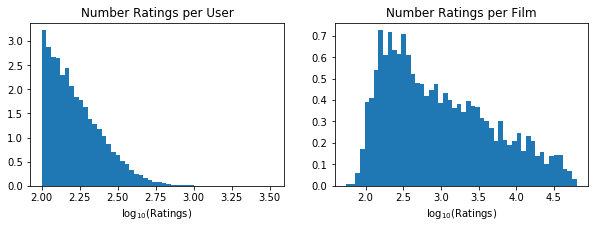

In [0]:
plt.rcParams['figure.figsize'] = (10,3)

plt.subplot(1,2,1)
H = plt.hist(np.log10(nb_rating_per_user), bins=50, density=True)
plt.xlabel(r"$\log_{10}$(Ratings)")
plt.title("Number Ratings per User")

plt.subplot(1,2,2)
H = plt.hist(np.log10(nb_rating_per_film), bins=50, density=True)
plt.xlabel(r"$\log_{10}$(Ratings)")
plt.title("Number Ratings per Film")


In [0]:
#split train / test data
n_train = int(n_ratings * 0.7)
data_train = data_netflix[:n_train,:]
data_test = data_netflix[n_train:,:]


First column is the userId, the second column is the movieId, and the third column is the rating. Your task is to develop an algorithm that can predict the rating of a given user for a given film. You will train your algorithm on the training set "data_train" and test performances on the test set contained in "data_test".

In [0]:
def RMSE_predictions(true_ratings, predictions):
    return np.sqrt(np.mean( (true_ratings - predictions)**2 ))

Let us first look at the performaces of the most naive and useless prediction: a random prediction.

In [0]:
random_predictions = 1+np.random.random(size=len(data_test))
RMSE_random_predictions =  RMSE_predictions(data_test[:,2], random_predictions)
print("RMSE of random predictions = ", RMSE_random_predictions)

RMSE of random predictions =  2.3166966740325363


Let us now look at the performaces of a slightly less naive and but as useless prediction: the global average.

In [0]:
global_average = np.zeros(len(data_test)) + np.mean(data_train[:,2])
RMSE_global_average =  RMSE_predictions(data_test[:,2], global_average)
print("RMSE of global_average predictions = ", RMSE_global_average)

RMSE of global_average predictions =  1.0722443896110023


### Task:
Use the ideas introduced in chapter "Matrix Completion" to build a recommendation system that can predict the ratings of the data contained in "data_test". You can only use the data contained in "data_train" to fit your model. Report the RMSE of your predictions on the test-set.

In [0]:
def Train_Dict(data_train, Type):
    ### Input: 
    ### Type = 1: Movie Mean; 
    ### Type = 0: User mean
    
    movie_user_train = data_train[:,Type]
    uniq_movie_user_train = np.unique(movie_user_train)
    rating_train = data_train[:,2]
    mean_dict = dict()
    
    for movie_user in uniq_movie_user_train:
        idx_movie_user = (movie_user_train == movie_user)
        selected = rating_train[idx_movie_user]
        mean_dict[movie_user] = [np.mean(selected), len(selected)]
    
    return mean_dict

def movie_user_avg(alpha, data_train, data_test, Type):
    mean_dict = Train_Dict(data_train, Type)

    # initialize with global mean
    rating_train = data_train[:,2]
    global_average = np.mean(rating_train)
    movie_user_average = np.zeros(len(data_test)) + global_average
    
    for i in range(len(data_test)):
        line = data_test[i,:]
        movie_user = line[Type]
        if movie_user in mean_dict:
            avg = mean_dict[movie_user][0]
            num_of_movie_user = mean_dict[movie_user][1]
            movie_user_average[i] = (alpha*global_average + num_of_movie_user*avg)\
                                /(alpha + num_of_movie_user)
    return movie_user_average


In [0]:
def loss_movie(alpha = 0):
    movie_average = movie_user_avg(alpha, data_train, data_test, 1)
    rating_test = data_test[:,2]
    return RMSE_predictions(rating_test, movie_average)

def loss_user(alpha = 0):
    user_average = movie_user_avg(alpha, data_train, data_test, 0)
    rating_test = data_test[:,2]
    return RMSE_predictions(rating_test, user_average)

In [0]:
RMSE_movie_average =  loss_movie()
print("RMSE of movie_avg predictions = ", RMSE_movie_average)

RMSE of movie_avg predictions =  0.9996226386647296


Use the BFGS Algorithm directly to approximate the ratings.
and using the test dataset to get the RMSE.

In [0]:
n_users = len(np.unique(data_train[:,0]))
n_films = len(np.unique(data_train[:,1]))
n_ratings = len(data_train)
print(n_users)

'''
user_agg = np.zeros(n_users)
user_num = np.zeros(n_users)
user_mean = np.zeros(n_users)
for k in range(n_ratings):
    user = data_train[k,0]
    film = data_train[k,1]
    rating = data_train[k,2]
    user_agg[user] +=rating
    user_num[user] +=1
for i in range(n_users):
  user_mean[i] = user_agg[i]/user_num[i]
'''

70775


'\nuser_agg = np.zeros(n_users)\nuser_num = np.zeros(n_users)\nuser_mean = np.zeros(n_users)\nfor k in range(n_ratings):\n    user = data_train[k,0]\n    film = data_train[k,1]\n    rating = data_train[k,2]\n    user_agg[user] +=rating\n    user_num[user] +=1\nfor i in range(n_users):\n  user_mean[i] = user_agg[i]/user_num[i]\n'

In [0]:
# we first define the naive recommendation matrix
def construct_naive_rating_matrix():
  ret = np.zeros((n_users, n_films))
  for k in range(n_ratings):
    user = data_train[k,0]
    film = data_train[k,1]
    rating = data_train[k,2]
    ret[user][film] = rating
  return ret

m_naive = construct_naive_rating_matrix()


In [0]:
m_naive.shape

(70775, 3314)

In [0]:
def loss(U,F):
    print("loss completed") # to check the status of the training process
    return np.mean( (m_naive - U @ F)**2 )

In [0]:
import scipy.optimize as scipy_optimize
#random initial guess 

p,q = m_naive.shape
r = 10  # rank of the approximation
U_init = np.random.normal(0,1,size=(p,r))
F_init = np.random.normal(0,1,size=(r,q))

In [0]:
from tqdm import tqdm

n_iter = 20
n_ter_BFGS = 10

U = np.copy(U_init)
F = np.copy(F_init)

loss_history = np.zeros(n_iter)

for k in tqdm(range(n_iter)):
    #update U with BFGS
    def L_F_fixed(U_flattenned):
        U = U_flattenned.reshape(p,r)
        return loss(U,F)
    gradient_L_F_fixed = grad(L_F_fixed)
    
    print("test 1") # to check the training process
    
    output_BFGS = scipy_optimize.minimize(L_F_fixed,
                                          U.flatten(), #initial guess
                                          method='L-BFGS-B', 
                                          jac=gradient_L_F_fixed,
                                          tol = 10**-8,
                                          options={"maxiter":n_ter_BFGS})
    U = output_BFGS["x"].reshape(p,r)  #set U to the output of BFGS
    
    print("test 2")  # to check the training process
    
    #update F with BFGS
    def L_U_fixed(F_flattenned):
        F = F_flattenned.reshape(r,q)
        return loss(U,F)
    gradient_L_U_fixed = grad(L_U_fixed)
    output_BFGS = scipy_optimize.minimize(L_U_fixed,
                                          F.flatten(), #initial guess
                                          method='L-BFGS-B', 
                                          jac=gradient_L_U_fixed,
                                          tol = 10**-8,
                                          options={"maxiter":n_ter_BFGS})
    F = output_BFGS["x"].reshape(r,q)  #set U to the output of BFGS
    
    #keep track of loss
    loss_history[k] = loss(U,F)
    print(loss_history[k])

  0%|          | 0/20 [00:00<?, ?it/s]

test 1
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
test 2
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed


  5%|▌         | 1/20 [20:03<6:20:58, 1203.07s/it]

0.41826916850699813
test 1
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
test 2
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed


 10%|█         | 2/20 [53:56<8:05:25, 1618.07s/it]

0.3664476513048115
test 1
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
test 2
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed


 15%|█▌        | 3/20 [1:18:25<7:24:24, 1568.51s/it]

0.36033387734449646
test 1
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
test 2
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed


 20%|██        | 4/20 [1:36:39<6:26:36, 1449.79s/it]

0.3589998375924785
test 1
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
test 2
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed


 25%|██▌       | 5/20 [1:54:35<5:43:46, 1375.09s/it]

0.3586032347057518
test 1
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
test 2
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed


 30%|███       | 6/20 [2:10:39<5:04:51, 1306.56s/it]

0.3584606801346133
test 1
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
test 2
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed


 35%|███▌      | 7/20 [2:24:35<4:28:31, 1239.38s/it]

0.35839698260360203
test 1
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
test 2
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed


 40%|████      | 8/20 [2:39:44<3:59:36, 1198.05s/it]

0.3583633766028732
test 1
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
test 2
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed


 45%|████▌     | 9/20 [2:55:45<3:34:48, 1171.67s/it]

0.3583437015804519
test 1
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
test 2
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed


 50%|█████     | 10/20 [3:09:24<3:09:24, 1136.43s/it]

0.35833142536503015
test 1
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
test 2
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed


 55%|█████▌    | 11/20 [3:22:29<2:45:40, 1104.50s/it]

0.35832318100539157
test 1
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
test 2
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed


 60%|██████    | 12/20 [3:58:01<2:38:40, 1190.10s/it]

0.3583176731031177
test 1
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
test 2
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed


 65%|██████▌   | 13/20 [4:18:03<2:18:57, 1191.04s/it]

0.3583139650712109
test 1
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
test 2
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed


 70%|███████   | 14/20 [4:32:23<1:56:44, 1167.38s/it]

0.35831132721303205
test 1
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
test 2
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed


 75%|███████▌  | 15/20 [4:47:59<1:35:59, 1151.97s/it]

0.35830939301018094
test 1
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
test 2
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed


 80%|████████  | 16/20 [5:03:30<1:15:52, 1138.15s/it]

0.35830800178255084
test 1
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
test 2
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed


 85%|████████▌ | 17/20 [5:16:02<55:46, 1115.46s/it]  

0.35830698209735257
test 1
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
test 2
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed


 90%|█████████ | 18/20 [5:29:29<36:36, 1098.32s/it]

0.35830624094436636
test 1
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
test 2
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed


 95%|█████████▌| 19/20 [5:42:14<18:00, 1080.77s/it]

0.3583056315065476
test 1
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
test 2
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed


100%|██████████| 20/20 [5:54:25<00:00, 1063.27s/it]

0.358305227800013


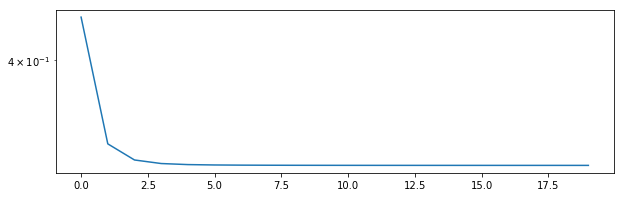

In [0]:
plt.plot(loss_history, "-")
plt.yscale("log")

In [0]:
trained_rating = U @ F

trained_predictions = np.zeros(len(data_test))
for i in range(len(data_test)):
  trained_predictions[i] = trained_rating[data_test[i,0]][data_test[i][1]]
RMSE_predictions(data_test[:,2], trained_predictions)

2.682975293779775

In [0]:
loss_history_1 = loss_history #  to store the old loss history

In [0]:
U_1, F_1 = U, F  # to store the old U and F

Use BFGS to approximate the residuals:

In [0]:
n_users = len(np.unique(data_train[:,0]))
n_films = len(np.unique(data_train[:,1]))
n_ratings = len(data_train)
print(n_users)

# define the naive model which is the user mean model
user_agg = np.zeros(n_users)
user_num = np.zeros(n_users)
user_mean = np.zeros(n_users)
for k in range(n_ratings):
    user = data_train[k,0]
    film = data_train[k,1]
    rating = data_train[k,2]
    user_agg[user] +=rating
    user_num[user] +=1
for i in range(n_users):
  user_mean[i] = user_agg[i]/user_num[i]


70775


In [0]:
# get the residual
residual = np.zeros((n_users, n_films))
for k in range(n_ratings):
    user = data_train[k,0]
    film = data_train[k,1]
    rating = data_train[k,2]
    residual[user][film] = rating - user_mean[user]

In [0]:
def L(U,F):
    print("loss completed")
    return np.mean( (residual - U @ F)**2 )

In [0]:
residual.shape

(70775, 3314)

In [0]:
import scipy.optimize as scipy_optimize
#random initial guess 

p,q = n_users, n_films
r = 10  # rank of the approximation
U_init = np.random.normal(0,1,size=(p,r))
F_init = np.random.normal(0,1,size=(r,q))

In [0]:
n_iter = 8  # Since in the last BFGS algorithm, the loss converges around 5 iterations. We choose 8 iterations this time as the algorithm costs a very long time
n_ter_BFGS = 10

U = np.copy(U_init)
F = np.copy(F_init)

loss_history_1 = np.zeros(n_iter)

for k in tqdm(range(n_iter)):
    #update U with BFGS
    def L_F_fixed(U_flattenned):
        U = U_flattenned.reshape(p,r)
        return L(U,F)
    gradient_L_F_fixed = grad(L_F_fixed)
    
    print("test 1") # to check the training process
    
    output_BFGS = scipy_optimize.minimize(L_F_fixed,
                                          U.flatten(), #initial guess
                                          method='L-BFGS-B', 
                                          jac=gradient_L_F_fixed,
                                          tol = 10**-8,
                                          options={"maxiter":n_ter_BFGS})
    U = output_BFGS["x"].reshape(p,r)  #set U to the output of BFGS
    
    print("test 2")  # to check the training process
    
    #update F with BFGS
    def L_U_fixed(F_flattenned):
        F = F_flattenned.reshape(r,q)
        return L(U,F)
    gradient_L_U_fixed = grad(L_U_fixed)
    output_BFGS = scipy_optimize.minimize(L_U_fixed,
                                          F.flatten(), #initial guess
                                          method='L-BFGS-B', 
                                          jac=gradient_L_U_fixed,
                                          tol = 10**-8,
                                          options={"maxiter":n_ter_BFGS})
    F = output_BFGS["x"].reshape(r,q)  #set U to the output of BFGS
    
    #keep track of loss
    loss_history[k] = loss(U,F)
    print(loss_history[k])

  0%|          | 0/8 [00:00<?, ?it/s]

test 1
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
test 2
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed


 12%|█▎        | 1/8 [20:21<2:22:29, 1221.41s/it]

0.5307007128429987
test 1
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
test 2
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed


 25%|██▌       | 2/8 [45:06<2:15:19, 1353.23s/it]

0.5216463496993796
test 1
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
test 2
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed


 38%|███▊      | 3/8 [1:09:00<1:55:00, 1380.13s/it]

0.5198958863846271
test 1
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
test 2
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed


 50%|█████     | 4/8 [1:31:43<1:31:43, 1375.97s/it]

0.519436664313221
test 1
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
test 2
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed


 62%|██████▎   | 5/8 [1:53:09<1:07:53, 1357.98s/it]

0.5192388742779548
test 1
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
test 2
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed


 75%|███████▌  | 6/8 [2:16:12<45:24, 1362.16s/it]  

0.5191400149428406
test 1
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
test 2
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed


 88%|████████▊ | 7/8 [2:36:25<22:20, 1340.72s/it]

0.5190893642994602
test 1
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
test 2
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed
loss completed


100%|██████████| 8/8 [2:55:47<00:00, 1318.43s/it]

0.5190655993821583


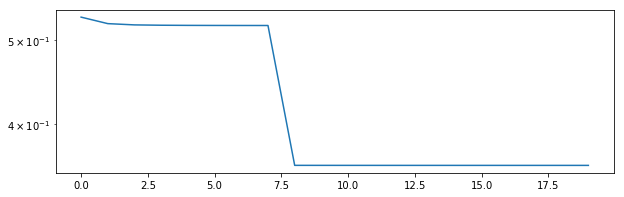

In [0]:
plt.plot(loss_history, "-")
plt.yscale("log")


In [0]:
trained_residual = U @ F

trained_predictions = np.zeros(len(data_test))
for i in range(len(data_test)):
  trained_predictions[i] = trained_residual[data_test[i,0]][data_test[i][1]] + user_mean[data_test[i,0]]
RMSE_predictions(data_test[:,2], trained_predictions)

0.9336482509685596

<h1><center>Exercise 2: image reconstruction</center></h1>

This exercise consists in reconstructing an image from a noisy versoin of it. 
1. The original image, "NUS.png", can be thought of as a matrix $M$.
2. One only observes a noissy version of it, $N$, defined as
$$
N_{i,j} = \mathbf{Poisson}(M_{i,j}).
$$
3. Your task is to reconstruct a good approximation of the original image based only on the noisy version $N$ of it.

In [0]:
#load the data
path = "/Users/apple/Downloads"
file = "NUS.png"

def read_image(path, file):
    """
    read an image, convert it to grayscale, normalize intensity pixels to (0,1)
    """
    img = np.array(Image.open(os.path.join(path, file)))
    return np.mean(img, axis=2) / 255.

In [0]:
#read the image
M = read_image(path, file)
print("Dimension of the Image:", M.shape)
 

Dimension of the Image: (182, 300)


In [0]:
#let us create a noisy version of it
N = np.random.poisson(M)

Text(0.5,1,'Noisy Image')

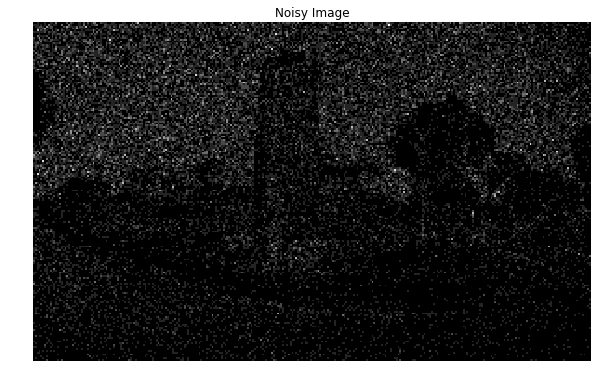

In [0]:
plt.rcParams['figure.figsize'] = (10,10)
plt.imshow(N, cmap = "gray")
plt.axis("off")
plt.title("Noisy Image")

In [0]:
#expand the matrix into an array
noisy = np.asarray(N).reshape(-1)
original=np.asarray(M).reshape(-1)
original.shape

(54600,)

In [0]:
def soft_thresholding(x, eta):
    xx = np.copy(x)
    xx[np.abs(xx) <= eta] = 0.
    xx[xx > eta] = xx[xx > eta] - eta
    xx[xx < -eta] = xx[xx < -eta] + eta    
    return xx

In [0]:
def proximal_op(X, threshold):
    U,d,V = np.linalg.svd(X)
    d = soft_thresholding(d, threshold)
    dimx, dimy = X.shape
    r = len(d) #min(N,p)
    D = np.zeros((dimx, dimy))
    D[:r, :r] =  np.diag(d[:r])
    return np.dot(U, np.dot(D,V))

In [0]:
def F(X, data):
    exp_X=np.exp(X)
    return np.mean( exp_X - np.multiply(data,X) )

grad_F = grad(F,argnum=0)

def loss(X, data, C):
    _,d,_ = np.linalg.svd(X)
    return F(X, data) + C * np.sum(d)

In [0]:
dim_x, dim_y = M.shape
X = np.random.random((dim_x, dim_y))
nb_iteration = 2000
learning_rate = 400
loss_history = np.zeros(nb_iteration)
C = 0.00005

for k in range(nb_iteration):
    #gradient along F
    gradient = grad_F(X, N)
    x_plus = X - learning_rate * gradient
    

    #proximal step along nuclear norm
    threshold = C * learning_rate
    x_new= proximal_op(x_plus, threshold)
    approx_grad = (X - x_new) / learning_rate
    while F(x_new,N ) > F(X, N) - learning_rate*np.sum(gradient * approx_grad) \
                            + 0.5*learning_rate*np.linalg.norm(approx_grad)**2:
            learning_rate = learning_rate / 2.
            x_plus = X - learning_rate * gradient 
            x_new = proximal_op(x_plus, learning_rate*C)
            approx_grad = (X - x_new) / learning_rate
    #update x
    X = x_new
    #keep track of loss
    loss_history[k] = loss(X, N, C)

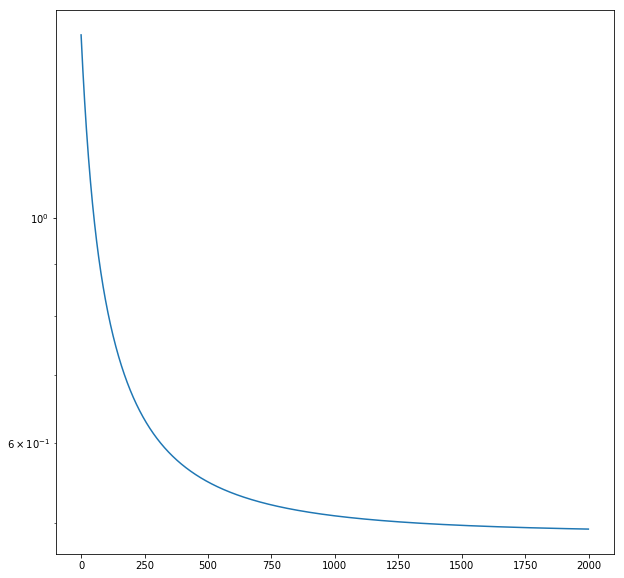

In [0]:
plt.plot(loss_history, "-")
plt.yscale("log")

Text(0.5,1,'Reconstructed Image')

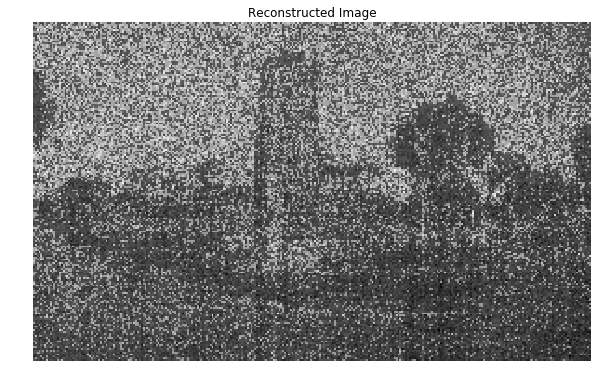

In [0]:
plt.imshow(X, cmap = "gray")
plt.axis("off")
plt.title("Reconstructed Image")

In [0]:
# ensures smoothnes
def G(X):
    return np.mean( (X[1:,:]-X[:-1,:])**2 ) + np.mean( (X[:, 1:]-X[:,:-1])**2 )

def loss(X, data, C):
    return F(X, data) + C*G(X)

grad_loss = grad(loss,argnum=0)

In [0]:
X = np.random.random((dim_x, dim_y))
nb_iteration = 5000
learning_rate = 100
loss_history = np.zeros(nb_iteration)
C = 0.001

for k in range(nb_iteration):
    #gradient along F
    gradient = grad_loss(X, N, C)
    X = X - learning_rate * gradient
    
    #keep track of loss
    loss_history[k] = loss(X, N, C)

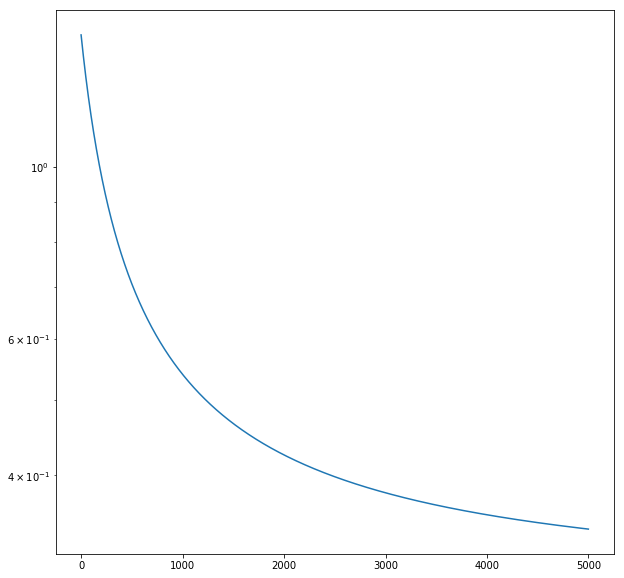

In [0]:
plt.plot(loss_history, "-")
plt.yscale("log")

In [0]:
loss_history

array([1.48097213, 1.47662069, 1.47230071, ..., 0.34072933, 0.34071738,
       0.34070542])

Text(0.5,1,'Reconstructed Image')

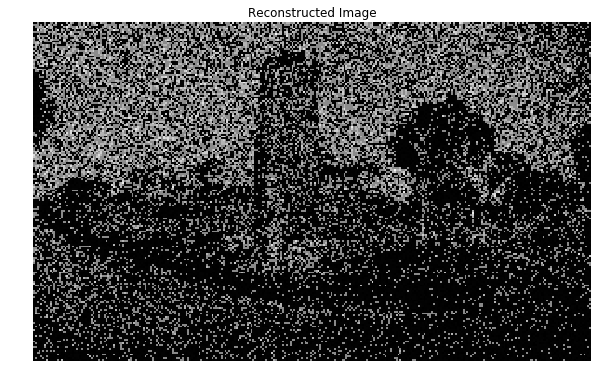

In [0]:
plt.imshow(X, cmap = "gray")
plt.axis("off")
plt.title("Reconstructed Image")